## Notebook 03: Fluid Thermodynamics
How to calculate fluid properties during phase changes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from importlib import reload
import sys

from iapws import IAPWS95
from mpl_toolkits.mplot3d import Axes3D

import warnings

from funcs import fluidthermo as ft

## generate the water phase diagram from IAPWS: 


/var/folders/1p/jdcprp414tsg3dl650mtvk780000gn/T/ipykernel_53446/2427632207.py:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(s_vap, T_range, 'k-', linewidth=3, label='Vap. Saturation Line', color='tab:grey')


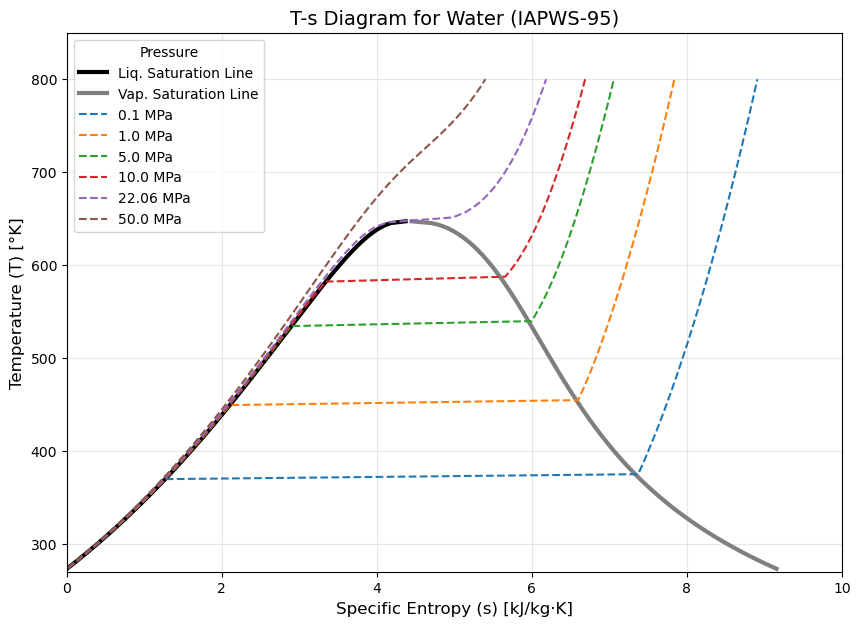

In [2]:


# 1. Generate the Saturation Curve (The "Bell")
T_crit = 647.096  # K
T_triple = 273.16 # K
T_range = np.linspace(T_triple, T_crit - 0.01, 200)

s_liq = []
s_vap = []

for T in T_range:
    sat = IAPWS95(T=T, x=0) # Saturated Liquid
    s_liq.append(sat.s)
    sat = IAPWS95(T=T, x=1) # Saturated Vapor
    s_vap.append(sat.s)

# 2. Generate Isobars
# Pressures in MPa
isobars = [0.1, 1.0, 5.0, 10.0, 22.06, 50.0] 
T_superheat_K = np.linspace(274, 800, 100)
T_superheat_C = T_superheat_K - 273.15

plt.figure(figsize=(10, 7))

# Plot Saturation Envelope
plt.plot(s_liq, T_range, 'k-', linewidth=3, label='Liq. Saturation Line')
plt.plot(s_vap, T_range, 'k-', linewidth=3, label='Vap. Saturation Line', color='tab:grey')

# Plot Isobars
for P in isobars:
    s_iso = []
    for T in T_superheat_K:
        try:
            # IAPWS95 takes T and P (MPa)
            state = IAPWS95(T=T, P=P)
            s_iso.append(state.s)
        except:
            s_iso.append(np.nan)
    
    plt.plot(s_iso, T_superheat_K, '--', label=f'{P} MPa')

# Formatting
plt.title("T-s Diagram for Water (IAPWS-95)", fontsize=14)
plt.xlabel("Specific Entropy (s) [kJ/kg·K]", fontsize=12)
plt.ylabel("Temperature (T) [°K]", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(title="Pressure")
plt.ylim(270, 850)
plt.xlim(0, 10)
plt.show()

## pull data from IAPWS equation of state and physical property calculator
(this is all you'll need in the next sections) <br>

In [3]:
reload(ft)
Pf_MPa = 30  # MPa
T_C = 500    # deg C
fluidprops = ft.FluidProps(Pf_MPa, T_C)
rho_f, eta_f, cp_f  = fluidprops.get_properties()
print(f"rho_f= {rho_f:.1f} kg/m3, eta_f= {eta_f:.4e} Pa.s, cp_f= {cp_f:.1f} J/kg/K")

rho_f= 115.1 kg/m3, eta_f= 3.1923e-05 Pa.s, cp_f= 4356.0 J/kg/K


## calculate the internal energy surface



In [9]:

from scipy.interpolate import griddata
# Suppress IAPWS warnings for metastable states
warnings.filterwarnings("ignore")


def generate_thermo_data():
    """
    Generates a dense point cloud of thermodynamic states (Liquid, Vapor, Supercritical).
    We calculate these in (T, P) space to ensure stability, then convert to (s, v, u).
    """
    print("1. Generating thermodynamic point cloud...")
    
    s_list, logv_list, u_list = [], [], []
    
    # --- A. Saturation Lines (The "Skeleton" of the plot) ---
    # These act as anchors for the interpolation
    T_crit = 647.096
    T_range_sat = np.linspace(274, T_crit - 0.1, 50)
    
    for T in T_range_sat:
        # Liquid State
        liq = IAPWS95(T=T, x=0)
        s_list.append(liq.s)
        logv_list.append(np.log10(1.0/liq.rho))
        u_list.append(liq.u)
        
        # Vapor State
        vap = IAPWS95(T=T, x=1)
        s_list.append(vap.s)
        logv_list.append(np.log10(1.0/vap.rho))
        u_list.append(vap.u)

    # --- B. Single Phase Regions (Liquid & Vapor) ---
    # We sweep Temperature and Pressure to fill the domain
    T_range = np.linspace(275, 900, 30)
    
    for T in T_range:
        # Determine Saturation Pressure (if below critical temp)
        if T < T_crit:
            P_sat = IAPWS95(T=T, x=0).P
            # Pressures: High (Compressed Liquid) -> Low (Superheated Vapor)
            # We skip the unstable region by jumping over P_sat
            P_liq = np.geomspace(P_sat * 1.01, 100, 15) # Compressed Liquid
            P_vap = np.geomspace(0.001, P_sat * 0.99, 15) # Superheated Vapor
            pressures = np.concatenate([P_liq, P_vap])
        else:
            # Supercritical: continuous pressure sweep
            pressures = np.geomspace(0.001, 100, 30)

        for P in pressures:
            try:
                state = IAPWS95(T=T, P=P)
                s_list.append(state.s)
                logv_list.append(np.log10(1.0/state.rho))
                u_list.append(state.u)
            except:
                pass
                
    return np.array(s_list), np.array(logv_list), np.array(u_list)

def create_regular_grid(s_pts, logv_pts, u_pts):
    """
    Interpolates the scattered point cloud onto a regular rectangular grid
    defined by Entropy (s) and Log Volume (log v).
    """
    print("2. Interpolating onto regular (s, log_v) grid...")
    
    # Define the target rectangular domain
    # We trim slightly to avoid edge artifacts
    s_min, s_max = 0.0, 9.0
    logv_min, logv_max = -3.0, 2.5
    
    # Create the meshgrid (higher resolution for smoothness)
    grid_s, grid_logv = np.meshgrid(
        np.linspace(s_min, s_max, 100),
        np.linspace(logv_min, logv_max, 100)
    )
    
    # Interpolate!
    # method='linear' is CRITICAL here. 
    # It creates flat triangles between the saturation lines, perfectly 
    # reproducing the "Ruled Surface" of the two-phase mixture region.
    grid_u = griddata(
        (s_pts, logv_pts), 
        u_pts, 
        (grid_s, grid_logv), 
        method='linear'
    )
    
    return grid_s, grid_logv, grid_u

def calculate_phase_lines():
    """Calculates clean lines for the red/blue phase boundaries."""
    T_crit = 647.096
    T_sat = np.linspace(274, T_crit - 0.5, 100)
    
    liq_s, liq_logv, liq_u = [], [], []
    vap_s, vap_logv, vap_u = [], [], []
    
    for T in T_sat:
        l = IAPWS95(T=T, x=0)
        v = IAPWS95(T=T, x=1)
        
        liq_s.append(l.s)
        liq_logv.append(np.log10(1.0/l.rho))
        liq_u.append(l.u)
        
        vap_s.append(v.s)
        vap_logv.append(np.log10(1.0/v.rho))
        vap_u.append(v.u)
        
    return (liq_s, liq_logv, liq_u), (vap_s, vap_logv, vap_u)




# 1. Get scattered data
s_raw, logv_raw, u_raw = generate_thermo_data()

# 2. Interpolate to square grid
g_s, g_lv, g_u = create_regular_grid(s_raw, logv_raw, u_raw)

# 3. Get lines
liq_d, vap_d = calculate_phase_lines()



1. Generating thermodynamic point cloud...
2. Interpolating onto regular (s, log_v) grid...


3. Plotting...


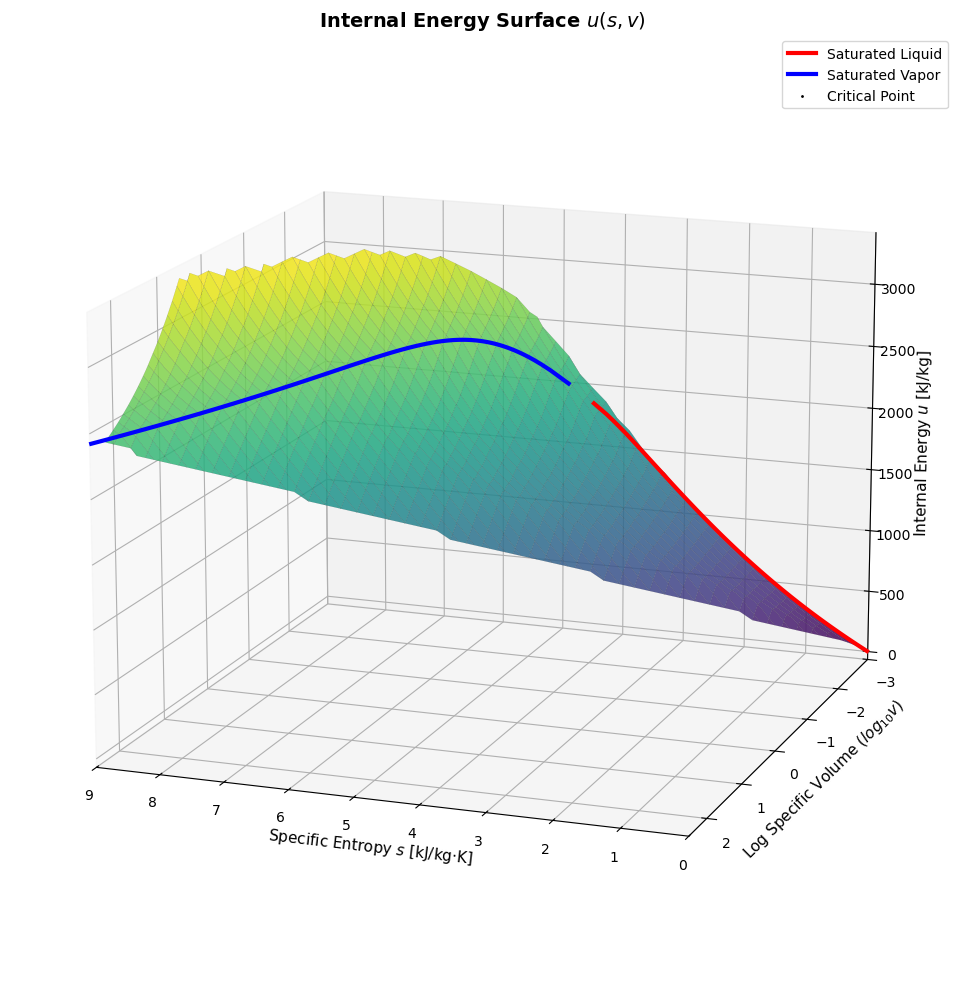

In [15]:
def plot_final_surface(grid_s, grid_logv, grid_u, liq_data, vap_data):
    print("3. Plotting...")
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # 1. Plot the Interpolated Surface
    surf = ax.plot_surface(grid_s, grid_logv, grid_u, cmap=cm.viridis,
                           edgecolor='k', linewidth=0.05, alpha=0.85, antialiased=True)
    
    # 2. Overlay Phase Boundaries (Thick Lines)
    # These will now lie perfectly flush with the surface because the surface 
    # includes them as interpolation anchors.
    ax.plot(liq_data[0], liq_data[1], liq_data[2], color='red', linewidth=3, label='Saturated Liquid', zorder=10)
    ax.plot(vap_data[0], vap_data[1], vap_data[2], color='blue', linewidth=3, label='Saturated Vapor', zorder=10)
    
    # 3. Critical Point
    try:
        cp = IAPWS95(T=647.096, x=0)
        ax.scatter(cp.s, np.log10(1.0/cp.rho), cp.u, color='black', s=100, label='Critical Point', zorder=20)
    except: pass

    # Formatting
    ax.set_xlabel('Specific Entropy $s$ [kJ/kg·K]', fontsize=11)
    ax.set_ylabel('Log Specific Volume ($log_{10} v$)', fontsize=11)
    ax.set_zlabel('Internal Energy $u$ [kJ/kg]', fontsize=11)
    ax.set_title('Internal Energy Surface $u(s, v)$', fontsize=14, fontweight='bold')
    
    # Set Domain Limits explicitly to match the grid
    ax.set_xlim(0, 9)
    ax.set_ylim(-3, 2.5)
    
    ax.view_init(elev=15, azim=110)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 4. Plot
plot_final_surface(g_s, g_lv, g_u, liq_d, vap_d)

## calculate the helmholtz free energy surface figure: 

In [4]:
# Suppress runtime warnings from within IAPWS (like the DeltaBd warning)
warnings.filterwarnings("ignore")


def calculate_helmholtz_surface():
    """
    Generates the T-v grid and calculates Helmholtz Free Energy (f)
    for the fundamental equation of state.
    """
    print("1. Calculating Helmholtz Surface (Fundamental Equation)...")
    
    # 1. Define Ranges (Natural Variables)
    # Temperature: Triple point (273.16K) to High Superheat (900K)
    T_vals = np.linspace(275, 900, 60)
    
    # Specific Volume: Logarithmic range to cover Liquid and Vapor
    # From compressed liquid (0.001 m3/kg) to superheated vapor (0.5 m3/kg)
    v_vals = np.geomspace(0.001, 0.5, 60)
    
    # Create Meshgrid
    T_grid, v_grid = np.meshgrid(T_vals, v_vals)
    f_grid = np.zeros_like(T_grid)
    
    # 2. Iterate and Calculate
    rows, cols = T_grid.shape
    for i in range(rows):
        for j in range(cols):
            T = T_grid[i, j]
            v = v_grid[i, j]
            rho_input = 1.0 / v  # Density = 1/v
            
            try:
                # Direct calculation from T and Density (Fundamental inputs)
                state = IAPWS95(T=T, rho=rho_input)
                
                # Helmholtz f = u - Ts [kJ/kg]
                # Using correct attribute .rho for density if needed
                f = state.u - (state.T * state.s)
                f_grid[i, j] = f
            except Exception:
                # If calculation fails (numerical instability), store NaN
                f_grid[i, j] = np.nan
                
    return T_grid, v_grid, f_grid

def calculate_phase_boundaries():
    """
    Calculates the Saturated Liquid and Saturated Vapor lines
    projected onto the Helmholtz surface.
    """
    print("2. Calculating Phase Boundaries...")
    
    # Iterate from near Triple Point to Critical Point
    T_crit = 647.096
    T_sat = np.linspace(275, T_crit - 0.1, 80)
    
    data = {
        'T': T_sat,
        'v_liq': [], 'f_liq': [],
        'v_vap': [], 'f_vap': []
    }
    
    for T in T_sat:
        try:
            # Saturated Liquid (x=0)
            liq = IAPWS95(T=T, x=0)
            v_l = 1.0 / liq.rho  # Corrected attribute: .rho
            f_l = liq.u - (T * liq.s)
            
            # Saturated Vapor (x=1)
            vap = IAPWS95(T=T, x=1)
            v_v = 1.0 / vap.rho  # Corrected attribute: .rho
            f_v = vap.u - (T * vap.s)
            
            data['v_liq'].append(v_l)
            data['f_liq'].append(f_l)
            data['v_vap'].append(v_v)
            data['f_vap'].append(f_v)
        except:
            # Skip points that fail to converge
            data['v_liq'].append(np.nan)
            data['f_liq'].append(np.nan)
            data['v_vap'].append(np.nan)
            data['f_vap'].append(np.nan)

    # Convert lists to arrays for plotting
    for key in ['v_liq', 'f_liq', 'v_vap', 'f_vap']:
        data[key] = np.array(data[key])
        
    return data


# 1. Get Surface Data
T_g, v_g, f_g = calculate_helmholtz_surface()
    
# 2. Get Phase Lines
phase_data = calculate_phase_boundaries()
    


1. Calculating Helmholtz Surface (Fundamental Equation)...
2. Calculating Phase Boundaries...


3. Generating Plot...


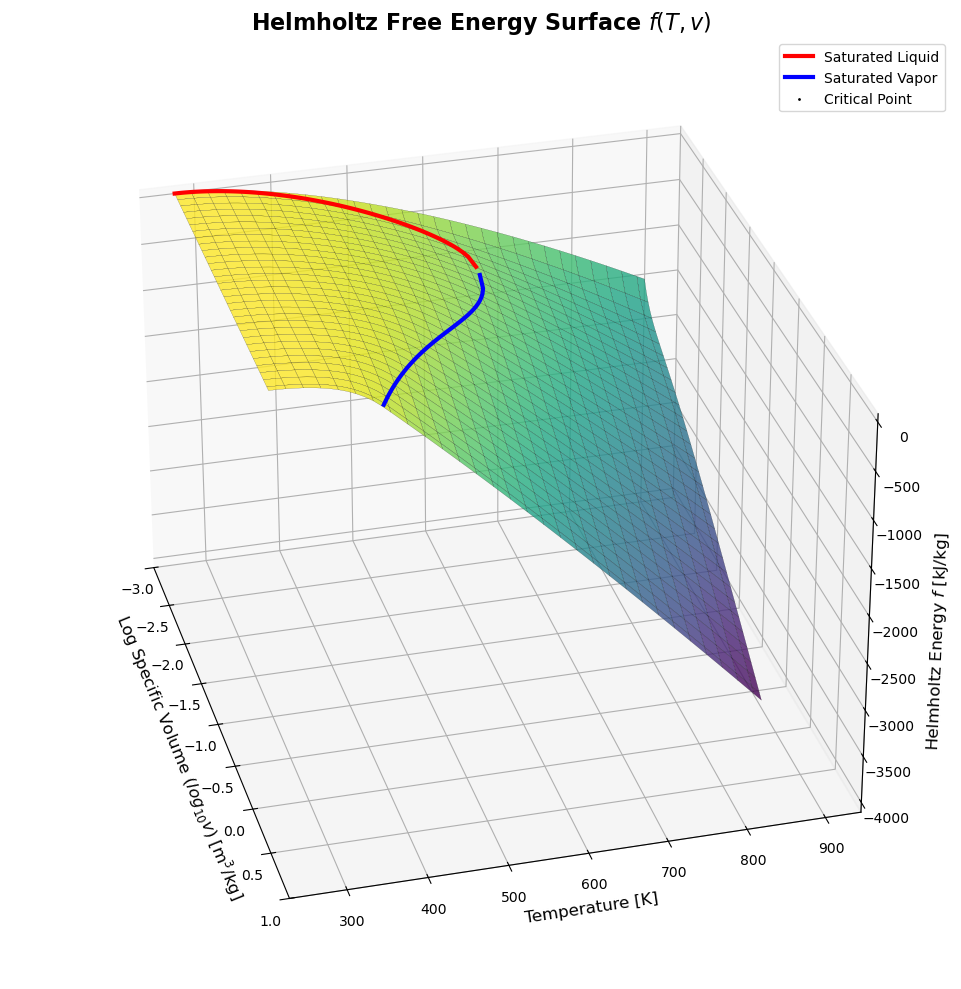

In [5]:
#     # 3. Plot
#     plot_thermo_surface(T_g, v_g, f_g, phase_data)


def plot_thermo_surface(T_grid, v_grid, f_grid, phase_data):
    """
    Plots the 3D surface and overlays the phase boundaries.
    """
    print("3. Generating Plot...")
    
    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Use Log10 of volume for the X-axis to make the plot readable
    log_v_grid = np.log10(v_grid)
    
    # 1. Plot the Surface (Fundamental Equation)
    surf = ax.plot_surface(log_v_grid, T_grid, f_grid, cmap=cm.viridis,
                           edgecolor='k', linewidth=0.1, alpha=0.8)
    
    # 2. Plot Phase Boundaries
    # We must also log10 the specific volume of the phase lines
    ax.plot(np.log10(phase_data['v_liq']), phase_data['T'], phase_data['f_liq'], 
            color='red', linewidth=3, label='Saturated Liquid', zorder=10)
    
    # trim the vapor line to avoid plotting beyond the range of specific volumes in the grid
    valid_vap_mask = (phase_data['v_vap'] >= np.min(v_grid)) & (phase_data['v_vap'] <= np.max(v_grid))
    ax.plot(np.log10(phase_data['v_vap'][valid_vap_mask]), phase_data['T'][valid_vap_mask], phase_data['f_vap'][valid_vap_mask], 
            color='blue', linewidth=3, label='Saturated Vapor', zorder=10)
    
    # 3. Plot Critical Point
    # Calculate CP manually to place it accurately
    try:
        cp_state = IAPWS95(T=647.096, x=0) # Quality doesn't matter at CP
        cp_v = 1.0 / cp_state.rho
        cp_f = cp_state.u - (647.096 * cp_state.s)
        ax.scatter(np.log10(cp_v), 647.096, cp_f, 
                   color='black', s=100, label='Critical Point', zorder=20)
    except:
        pass # Skip if CP fails to converge exactly

    # Formatting
    ax.set_xlabel('Log Specific Volume ($log_{10} v$) [m$^3$/kg]', fontsize=12)#, labelpad=10)
    ax.set_xlim(-3, 1)  # Adjust limits for log scale
    ax.set_ylabel('Temperature [K]', fontsize=12)#, labelpad=10)
    ax.set_zlabel('Helmholtz Energy $f$ [kJ/kg]', fontsize=12, labelpad=10)
    ax.set_title('Helmholtz Free Energy Surface $f(T, v)$', fontsize=16, fontweight='bold')
    
    # Set view angle
    ax.view_init(elev=30, azim=-15)
    
    # Legend
    ax.legend()
    
    plt.tight_layout()
    #plt.subplots_adjust(left=-0.5, right=0.0, top=0.9, bottom=0.1)
    ax.set_box_aspect([1, 0.9, 0.7])  # x:y:z ratio
    
    plt.show()



# 3. Plot ==========================================
plot_thermo_surface(T_g, v_g, f_g, phase_data)


## calculate the physical properties from the IAPWS95 module: 

Calculation complete. Generating plots...


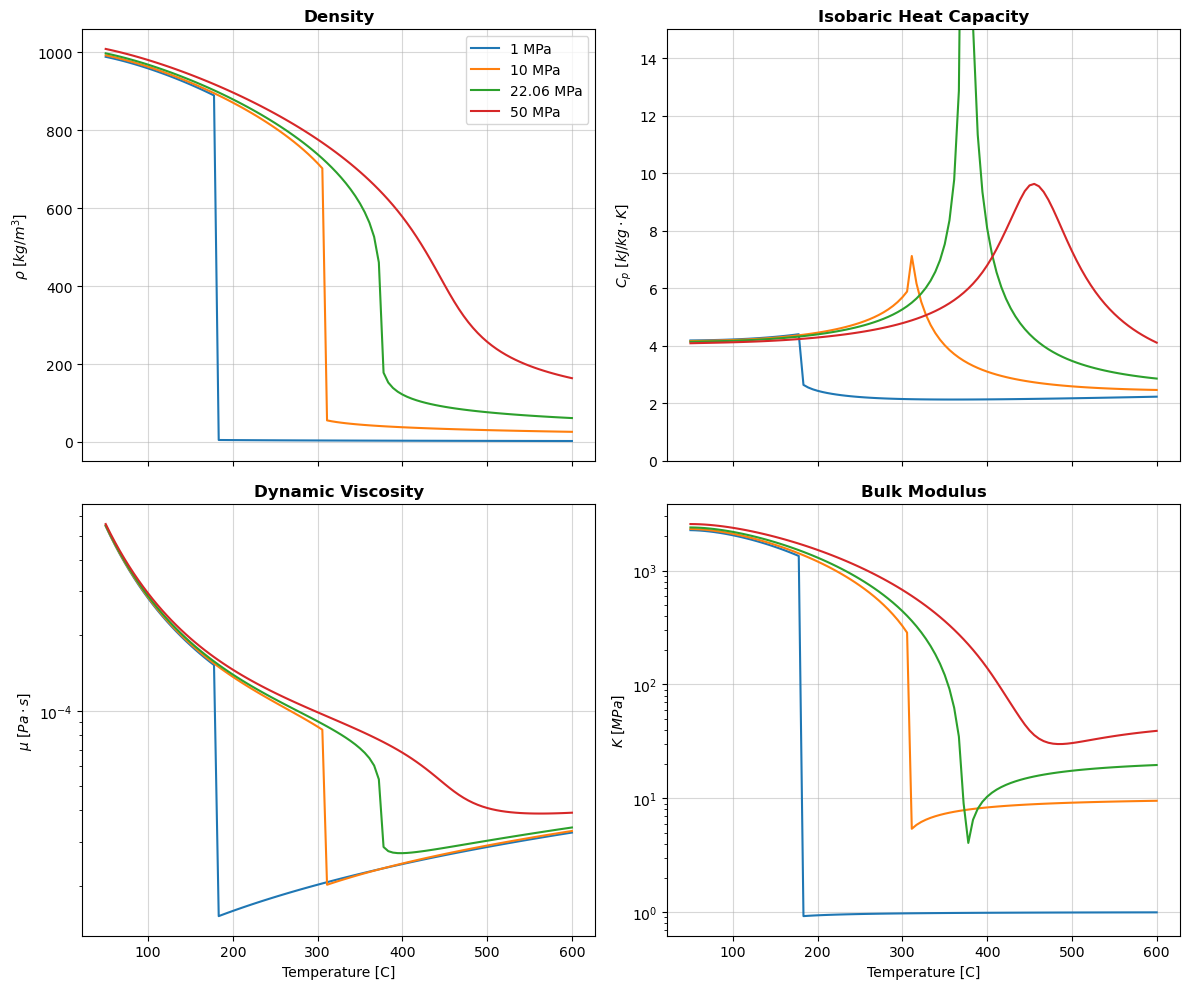

In [6]:


# 2. Setup Ranges
temps_c = np.linspace(50, 600, 100)  # Reduced points slightly for speed/stability
pressures_mpa = [1, 10, 22.06, 50]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# 3. Data Collection (With Error Reporting)
results = {p: {prop: [] for prop in ['rho', 'cp', 'mu', 'K']} for p in pressures_mpa}

# Debug flag to print the first error only once
error_reported = False 

for p in pressures_mpa:
    for tc in temps_c:
        T_kelvin = tc + 273.15
        
        # Initialize placeholders as NaN
        rho, cp, mu, K = np.nan, np.nan, np.nan, np.nan
        
        try:
            # Create State Object
            state = IAPWS95(T=T_kelvin, P=p)
            
            # Extract Properties individually
            try: rho = state.rho
            except: pass
            
            try: cp = state.cp
            except: pass
            
            try: mu = state.mu
            except: pass
            
            try: 
                # Avoid division by zero if kappa is 0 or invalid
                if hasattr(state, 'kappa') and state.kappa > 1e-10:
                    K = 1.0 / state.kappa 
            except: pass

        except Exception as e:
            # If the state calculation itself fails (e.g. non-convergence)
            if not error_reported:
                print(f"Calculation warning at {tc:.1f}°C, {p} MPa: {e}")
                error_reported = True
        
        # Store results
        results[p]['rho'].append(rho)
        results[p]['cp'].append(cp)
        results[p]['mu'].append(mu)
        results[p]['K'].append(K)

# 4. Plotting
print("Calculation complete. Generating plots...")
fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharex=True)

for i, p in enumerate(pressures_mpa):
    label = f"{p} MPa"
    c = colors[i]
    
    # Filter out NaNs for clean plotting
    # (Matplotlib handles NaNs by breaking the line, which is what we want)
    axs[0, 0].plot(temps_c, results[p]['rho'], label=label, color=c)
    axs[0, 1].plot(temps_c, results[p]['cp'], label=label, color=c)
    axs[1, 0].plot(temps_c, results[p]['mu'], label=label, color=c)
    axs[1, 1].plot(temps_c, results[p]['K'], label=label, color=c)

# Formatting
titles = [
    ('Density', r'$\rho$ [$kg/m^3$]'),
    ('Isobaric Heat Capacity', r'$C_p$ [$kJ/kg\cdot K$]'),
    ('Dynamic Viscosity', r'$\mu$ [$Pa\cdot s$]'),
    ('Bulk Modulus', r'$K$ [$MPa$]')
]

coords = [(0,0), (0,1), (1,0), (1,1)]

for (r, c), (title, ylabel) in zip(coords, titles):
    ax = axs[r, c]
    ax.set_title(title, fontweight='bold')
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.5)
    
    # Special scaling for Cp to hide the infinite spike at critical point
    if 'Capacity' in title:
        ax.set_ylim(0, 15)

# X-axis labels on bottom row only
axs[1, 0].set_xlabel('Temperature [C]')
axs[1, 1].set_xlabel('Temperature [C]')

# log bottom row only
axs[1, 0].set_yscale('log')
axs[1, 1].set_yscale('log')

# Legend only on first plot to save space
axs[0, 0].legend()

plt.tight_layout()
plt.show()